<a href="https://colab.research.google.com/github/nitinsharma006/data_science/blob/master/Neural%20Networks/Emergency_vs_Non_Emergency_Vehicle_Sound_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Overview

By the end of this notebook, you will understand how to-

* Work with the audio data
* Represent an audio data - Time Domain and Spectrogram
* Build a deep learning model while working with audio data


# Understanding the Problem Statement

According to the National Crime Records Bureau, nearly 24,012 people die each day due to a delay in getting medical assistance

Nearly 4,40,042 accident cases are reported across the country each year, of which 1,39,091 people lose their life. The first hour after the incident, or the Golden Hour, is critical. Many accident victims wait for help at the site, and a delay costs them their life. The reasons could range from ambulances stuck in traffic to the fire brigade not being able to reach the site on time due to traffic jams 

![alt text](https://drive.google.com/uc?id=1jO01r94g_1Xg0lf_ESPO0hnGOA0x1Aj1)


The solution to the above problem is to create an alarm system which detects the emergency vehicle prior to reaching the traffic signals and change the traffic signals accordingly.

# Dataset

Download the dataset from [here](https://drive.google.com/file/d/1VBI_X6GyYvf8j3T70-_hVDyhR_sUzeCr/view?usp=sharing)

# Implementation


So, in this notebook, let us create a deep learning model to detect the emergency vehicle based on the audio. 



**Import Libraries**

Let us first import the libraries into our environment

* **Librosa** is an open source library in Python that is used audio and music analyis

* **Scipy** is a python library for scientific & technical computing. It contains modules for signal processing, image processing, linear algebera and so on.

In [1]:
#Audio Processing Libraries
import librosa
from scipy import signal

#For Playing Audio
import IPython.display as ipd

#Array Processing
import numpy as np

#Data Visualization 
import matplotlib.pyplot as plt

**What is an Audio signal?**

When an object vibrates, the air molecules oscillate to and fro from their rest position and transmits its energy to neighboring molecules. This results in the transmission of energy from one molecule to another which in turn produces a sound wave.



![alt text](https://drive.google.com/uc?id=1fUPHlzsGRhtv-L_-nHpV5kYtq8KdZwZV)

**How to analyze Audio Signal?**


**Time Domain**

Let us analyze the audio data in time domain now. Librosa loads an audio file as a floating point time series according to the user specified sampling rate

![alt text](https://drive.google.com/uc?id=1LZuYPQPRFnxTtwD_oMYTuHQ2uXAud3Gm)


**Sampling Rate** is defined as the no. of samples per second. For example, consider an audio wave of 2 seconds with a sampling rate of 16,000 (that is 16,000 samples per second). Now, we will have 32,000 samples recorded at different intervals of 2 seconds

Let us read the audio signal with sampling rate of 16000 

In [3]:
#!unzip 'drive/My Drive/audio.zip'

path='emergency.wav'
emergency,sample_rate    = librosa.load(path, sr = 16000)

path='non emergency.wav'
non_emergency,sample_rate= librosa.load(path, sr =16000)

Compute the duration of a clip

In [4]:
duration1 = librosa.get_duration(emergency,sr=16000)
duration2 = librosa.get_duration(non_emergency,sr=16000)

print("Duration of an emergency and Non Emergency (in min):",duration1/60,duration2/60)

Duration of an emergency and Non Emergency (in min): 22.920290625 27.160834375


**Preparing Data**

Let us break the audio into chunks of 2 seconds. So, let us define the function for the same task

In [5]:
def prepare_data(samples, num_of_samples=32000, num_of_common=16000):
  
  data=[]
  for offset in range(0, len(samples), num_of_common):
    start = offset
    end   = offset + num_of_samples
    chunk = samples[start:end]
    
    if(len(chunk)==32000):
      data.append(chunk)
    
  return data

Call the above function

In [6]:
emergency = prepare_data(emergency)
non_emergency = prepare_data(non_emergency)

In [7]:
print("No. of Chunks of Emergency and Non Emergency:",len(emergency),len(non_emergency))

No. of Chunks of Emergency and Non Emergency: 1374 1628


Lets listen to some of the clips

In [8]:
ipd.Audio(emergency[100],rate=16000)

In [9]:
ipd.Audio(emergency[136],rate=16000)

In [10]:
ipd.Audio(non_emergency[200],rate=16000)

In [11]:
ipd.Audio(non_emergency[10],rate=16000)

**Visualization of an Audio wave**

Lets visualize the audio wave in time domain

Text(0, 0.5, 'Amplitude')

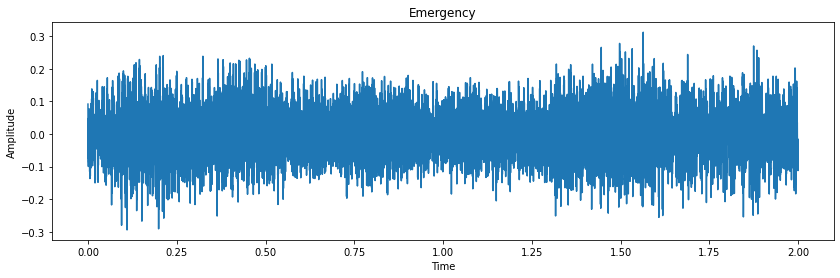

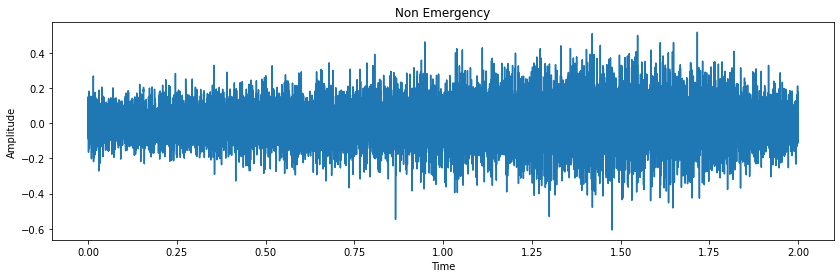

In [12]:
plt.figure(figsize=(14,4))
plt.plot(np.linspace(0, 2, num=32000),emergency[103])
plt.title('Emergency')
plt.xlabel('Time')
plt.ylabel('Amplitude')

plt.figure(figsize=(14,4))
plt.plot(np.linspace(0, 2, num=32000),non_emergency[102])
plt.title('Non Emergency')
plt.xlabel('Time')
plt.ylabel('Amplitude')

Combine Emergecy and Non Emergency chunks

In [13]:
audio = np.concatenate([emergency,non_emergency])

Create the output label based on the no. of chunks in each class

In [14]:
labels1 = np.zeros(len(emergency))
labels2 = np.ones(len(non_emergency))

labels = np.concatenate([labels1,labels2])

Take a glance at the shape of the audio waves

In [15]:
print(audio.shape)

(3002, 32000)


**Split into train and validation set**

Next, we will train the model on 90% of the data and validate on the remaining 10%:

In [16]:
from sklearn.model_selection import train_test_split
x_tr, x_val, y_tr, y_val = train_test_split(np.array(audio),np.array(labels),stratify=labels,test_size = 0.1,random_state=777,shuffle=True)

The input to the conv1d must be 3 dimensional array - (no. of samples, timesteps, features)

So, lets reshape our input array according to the required shape

In [17]:
x_tr_features  = x_tr.reshape(len(x_tr),-1,1)
x_val_features = x_val.reshape(len(x_val),-1,1)

print("Reshaped Array Size",x_tr_features.shape)

Reshaped Array Size (2701, 32000, 1)


**Model Architecture**

Lets define the model architecture using conv1D layers as it performs convolution only along one dimension

In [18]:
from keras.layers import *
from keras.models import *
from keras.callbacks import *
from keras import backend as K

def conv1d(x_tr):
  K.clear_session()
  inputs = Input(shape=(x_tr.shape[1],x_tr.shape[2]))

  #First Conv1D layer
  conv = Conv1D(8, 13, padding='same', activation='relu')(inputs)
  conv = Dropout(0.3)(conv)
  conv = MaxPooling1D(2)(conv)

  #Second Conv1D layer
  conv = Conv1D(16, 11, padding='same', activation='relu')(conv)
  conv = Dropout(0.3)(conv)
  conv = MaxPooling1D(2)(conv)

  #MaxPooling 1D
  conv = GlobalMaxPool1D()(conv)

  #Dense Layer 
  conv = Dense(16, activation='relu')(conv)
  outputs = Dense(1,activation='sigmoid')(conv)

  model = Model(inputs, outputs)
  
  model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['acc'])
  model_checkpoint = ModelCheckpoint('best_model.hdf5', monitor='val_acc', verbose=1, save_best_only=True, mode='max')
  
  return model, model_checkpoint

Define the model:

In [19]:
model, model_checkpoint = conv1d(x_tr_features)

Understand the shape and parameters at each layer

In [20]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32000, 1)]        0         
                                                                 
 conv1d (Conv1D)             (None, 32000, 8)          112       
                                                                 
 dropout (Dropout)           (None, 32000, 8)          0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 16000, 8)         0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 16000, 16)         1424      
                                                                 
 dropout_1 (Dropout)         (None, 16000, 16)         0         
                                                             

Lets train the model for 10 epochs with batch size of 32:

In [21]:
history=model.fit(x_tr_features, y_tr ,epochs=10, callbacks=[model_checkpoint], batch_size=32, validation_data=(x_val_features,y_val))

Epoch 1/10
85/85 [==============================] - ETA: 0s - loss: 0.6099 - acc: 0.7079
Epoch 1: val_acc improved from -inf to 0.78405, saving model to best_model.hdf5
85/85 [==============================] - 15s 59ms/step - loss: 0.6099 - acc: 0.7079 - val_loss: 0.5815 - val_acc: 0.7841
Epoch 2/10
84/85 [============================>.] - ETA: 0s - loss: 0.4455 - acc: 0.8296
Epoch 2: val_acc improved from 0.78405 to 0.85050, saving model to best_model.hdf5
85/85 [==============================] - 5s 55ms/step - loss: 0.4451 - acc: 0.8297 - val_loss: 0.4600 - val_acc: 0.8505
Epoch 3/10
84/85 [============================>.] - ETA: 0s - loss: 0.3536 - acc: 0.8609
Epoch 3: val_acc improved from 0.85050 to 0.86379, saving model to best_model.hdf5
85/85 [==============================] - 5s 54ms/step - loss: 0.3531 - acc: 0.8612 - val_loss: 0.3996 - val_acc: 0.8638
Epoch 4/10
84/85 [============================>.] - ETA: 0s - loss: 0.3225 - acc: 0.8635
Epoch 4: val_acc improved from 0.8637

Load the best model

In [22]:
model.load_weights('best_model.hdf5')

Evaluate the model on hold out set

In [23]:
_, acc = model.evaluate(x_val_features,y_val)
print("Validation Accuracy:",acc)

10/10 [==============================] - 0s 27ms/step - loss: 0.3573 - acc: 0.8704
Validation Accuracy: 0.8704319000244141


**Inference**

Let us make predictions on the hold out set

In [24]:
ind=35
test_audio = x_val[ind]
ipd.Audio(test_audio,rate=16000)

In [25]:
feature = x_val_features[ind]
prob = model.predict(feature.reshape(1,-1,1))
if (prob[0][0] < 0.5 ):
  pred='emergency'
else:
  pred='non emergency' 

print("Prediction:",pred)

Prediction: emergency


In [26]:
#lstm 

In [27]:
x_tr_features  = x_tr.reshape(len(x_tr),-1,160)
x_val_features = x_val.reshape(len(x_val),-1,160)

print("Reshaped Array Size",x_tr_features.shape)

Reshaped Array Size (2701, 200, 160)


In [28]:
def lstm(x_tr):
  K.clear_session()
  inputs = Input(shape=(x_tr.shape[1],x_tr.shape[2]))

  #lstm
  x = LSTM(128)(inputs)
  x = Dropout(0.3)(x)
  
  #dense
  x= Dense(64,activation='relu')(x)
  x= Dense(1,activation='sigmoid')(x)
  
  model = Model(inputs, x)

  model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['acc'])
  
  return model

In [29]:
model, mc = lstm(x_tr_features)

TypeError: ignored

In [ ]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 200, 160)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               147968    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 156,289
Trainable params: 156,289
Non-trainable params: 0
_________________________________________________________________


In [ ]:
mc = ModelCheckpoint('best_model.hdf5', monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [ ]:
history=model.fit(x_tr_features, y_tr, epochs=10, callbacks=[mc], batch_size=32, validation_data=(x_val_features,y_val))




Train on 2701 samples, validate on 301 samples
Epoch 1/10





2701/2701 [==============================] - 41s 15ms/step - loss: 0.6699 - acc: 0.6087 - val_loss: 0.6491 - val_acc: 0.6611

Epoch 00001: val_acc improved from -inf to 0.66113, saving model to best_model.hdf5
Epoch 2/10
2701/2701 [==============================] - 32s 12ms/step - loss: 0.5817 - acc: 0.7105 - val_loss: 0.5288 - val_acc: 0.7674

Epoch 00002: val_acc improved from 0.66113 to 0.76744, saving model to best_model.hdf5
Epoch 3/10
2701/2701 [==============================] - 32s 12ms/step - loss: 0.6257 - acc: 0.7146 - val_loss: 0.5310 - val_acc: 0.7641

Epoch 00003: val_acc did not improve from 0.76744
Epoch 4/10
2701/2701 [==============================] - 32s 12ms/step - loss: 0.4876 - acc: 0.8182 - val_loss: 0.4554 - val_acc: 0.8605

Epoch 00004: val_acc improved from 0.76744 to 0.86047, saving model to best_model.hdf5
Epoch 5/10
2701/2701 [==============================] - 31s 12ms/step - loss: 0.5114 - ac

In [ ]:
model.load_weights('best_model.hdf5')

In [ ]:
_,acc = model.evaluate(x_val_features,y_val)
print("Accuracy:",acc)

301/301 [==============================] - 1s 5ms/step
Accuracy: 0.920265780730897


In [ ]:
ind=1
test_audio = x_val[ind]
ipd.Audio(test_audio,rate=16000)

In [ ]:
feature = x_val_features[ind]
prob = model.predict(feature.reshape(1,-1,feature.shape[1]))
if (prob[0][0] < 0.5 ):
  pred='emergency'
else:
  pred='non emergency' 
print("Prediction:",pred)

Prediction: emergency


## Spectrogram

Ever heard of a spectrogram? It’s a 2D plot between time and frequency where each point in the plot represents the amplitude of a particular frequency at a particular time in terms of intensity of color. In simple terms, the spectrogram is a spectrum (broad range of colors) of frequencies as it varies with time. 

Let us define a function that computes the spectrogram. Before that, we need to understand how the spectrogram is computed.

Spectrogram accepts the raw audio wave and then breaks it into chunks or windows and then applies FFT on each window to compute the frequencies.

Coming to the parameters for computing spectrogram: 

* nperseg = Size of the window i.e. no. of samples in each chunk
* noverlap= No. of overlapping samples between each window

In [ ]:
def log_specgram(audio, sample_rate, eps=1e-10):
    nperseg  = 320
    noverlap = 160
    freqs, times, spec = signal.spectrogram(audio,fs=sample_rate, nperseg=nperseg,noverlap=noverlap,detrend=False)
    return freqs, times, np.log(spec.T.astype(np.float32) + eps)

Define a function for representing spectrogram:

In [ ]:
def plot(spectrogram,label):
  fig = plt.figure(figsize=(14, 8))
  ax = fig.add_subplot(211)
  ax.imshow(spectrogram.T, aspect='auto', origin='lower',extent=[times.min(), times.max(), freqs.min(), freqs.max()])
  ax.set_title('Spectrogram of '+label)
  ax.set_ylabel('Freqs in Hz')
  ax.set_xlabel('Seconds')

Compute the spectrogram:

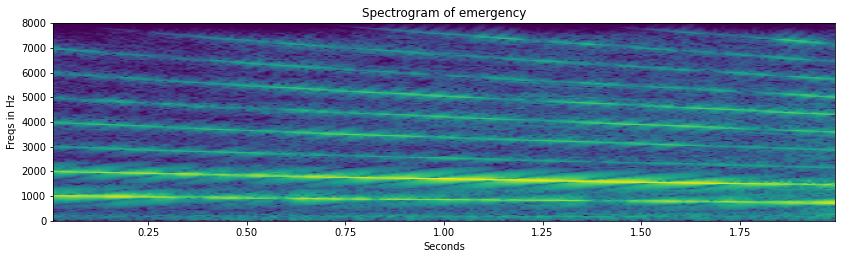

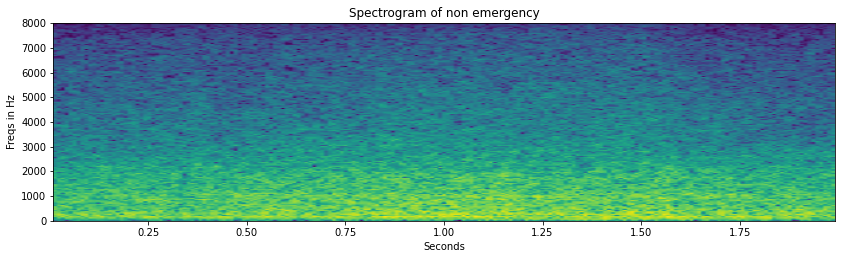

In [ ]:
freqs, times, spectrogram = log_specgram(emergency[300], sample_rate)
plot(spectrogram,"emergency")

freqs, times, spectrogram = log_specgram(non_emergency[300], sample_rate)
plot(spectrogram,"non emergency")

Understand the shape of the spectrogram:

In [ ]:
spectrogram.shape

(199, 161)

array([-15.575486 , -12.7084675, -10.321972 , -10.88457  , -13.834395 ,
       -11.873345 , -12.735329 , -10.884907 , -11.905026 , -12.934278 ,
       -11.877053 , -12.938899 , -10.983666 , -13.229616 , -12.708224 ,
       -13.509246 , -13.072082 , -12.255045 , -11.2173   , -12.414617 ,
       -14.078011 , -13.788856 , -13.033925 , -14.271732 , -13.406035 ,
       -14.840687 , -13.030424 , -13.702069 , -12.194617 , -11.808323 ,
       -13.498567 , -14.070996 , -13.045364 , -12.865691 , -15.32106  ,
       -14.645406 , -13.01926  , -11.747046 , -15.439046 , -12.791425 ,
       -12.659919 , -15.946685 , -12.676854 , -14.271466 , -14.438596 ,
       -13.373798 , -15.43779  , -14.18673  , -15.91461  , -17.066963 ,
       -14.880674 , -17.846455 , -13.438975 , -14.584175 , -15.099297 ,
       -15.432151 , -17.176888 , -14.46726  , -14.187905 , -16.284077 ,
       -17.996298 , -19.971926 , -15.289653 , -15.974499 , -15.171322 ,
       -16.025553 , -16.350607 , -16.872051 , -14.942889 , -17.5

Extract the spectrogram features

In [ ]:
def extract_spectrogram_features(x_tr):
  features=[]
  for i in x_tr:
    _, _, spectrogram = log_specgram(i, sample_rate)
    
    mean = np.mean(spectrogram, axis=0)
    std = np.std(spectrogram, axis=0)
    spectrogram = (spectrogram - mean) / std
    
    features.append(spectrogram)

  return np.array(features)

In [ ]:
x_tr_features  = extract_spectrogram_features(x_tr)
x_val_features = extract_spectrogram_features(x_val)

**Define architecture**

Now, we will define the LSTM architecture for solving the task

In [ ]:
def lstm(x_tr):
  K.clear_session()
  inputs = Input(shape=(x_tr.shape[1],x_tr.shape[2]))

  #lstm
  x = LSTM(128)(inputs)
  x = Dropout(0.3)(x)
  
  #dense
  x= Dense(64,activation='relu')(x)
  x= Dense(1,activation='sigmoid')(x)
  
  model = Model(inputs, x)

  model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['acc'])

  mc = ModelCheckpoint('best_model.hdf5', monitor='val_acc', verbose=1, save_best_only=True, mode='max')
  
  return model,mc

Define the model:

In [ ]:
model, mc = lstm(x_tr_features)

Understand the no. of parameters and shape of each layer:

In [ ]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 199, 161)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               148480    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 156,801
Trainable params: 156,801
Non-trainable params: 0
_________________________________________________________________


Train the model

In [ ]:
history=model.fit(x_tr_features, y_tr, epochs=10, callbacks=[mc], batch_size=32, validation_data=(x_val_features,y_val))

Train on 2701 samples, validate on 301 samples
Epoch 1/10
2701/2701 [==============================] - 27s 10ms/step - loss: 0.6374 - acc: 0.6279 - val_loss: 0.5274 - val_acc: 0.7641

Epoch 00001: val_acc improved from -inf to 0.76412, saving model to best_model.hdf5
Epoch 2/10
2701/2701 [==============================] - 26s 10ms/step - loss: 0.3691 - acc: 0.8652 - val_loss: 0.2670 - val_acc: 0.9169

Epoch 00002: val_acc improved from 0.76412 to 0.91694, saving model to best_model.hdf5
Epoch 3/10
2701/2701 [==============================] - 26s 10ms/step - loss: 0.3280 - acc: 0.8775 - val_loss: 0.2355 - val_acc: 0.9136

Epoch 00003: val_acc did not improve from 0.91694
Epoch 4/10
2701/2701 [==============================] - 28s 10ms/step - loss: 0.2572 - acc: 0.9119 - val_loss: 0.2391 - val_acc: 0.9169

Epoch 00004: val_acc did not improve from 0.91694
Epoch 5/10
2701/2701 [==============================] - 26s 10ms/step - loss: 0.1806 - acc: 0.9382 - val_loss: 0.2726 - val_acc: 0.897

Load the weights of the best model:

In [ ]:
model.load_weights('best_model.hdf5')

Evaluating the performance of the model on validation set:

In [ ]:
_,acc = model.evaluate(x_val_features,y_val)
print("Accuracy:",acc)

301/301 [==============================] - 1s 4ms/step
Accuracy: 0.9169435217927064


**Inference**

Let us make predictions on the validation data

In [ ]:
ind=1
test_audio = x_val[ind]
ipd.Audio(test_audio,rate=16000)

In [ ]:
feature = x_val_features[ind]
prob = model.predict(feature.reshape(1,-1,feature.shape[1]))
if (prob[0][0] < 0.5 ):
  pred='emergency'
else:
  pred='non emergency' 
print("Prediction:",pred)

Prediction: emergency


Lets train conv1d on the same spectrogram features. So, lets define the conv1d model


In [ ]:
model, mc = conv1d(x_tr_features)

Understand the input and output shape of each layer:

In [ ]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 199, 161)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 199, 8)            16752     
_________________________________________________________________
dropout_1 (Dropout)          (None, 199, 8)            0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 99, 8)             0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 99, 16)            1424      
_________________________________________________________________
dropout_2 (Dropout)          (None, 99, 16)            0         
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 49, 16)            0   

Training the model:

In [ ]:
history=model.fit(x_tr_features, y_tr, epochs=10, callbacks=[mc], batch_size=32, validation_data=(x_val_features,y_val))

Train on 2701 samples, validate on 301 samples
Epoch 1/10
2701/2701 [==============================] - 1s 526us/step - loss: 0.7189 - acc: 0.6720 - val_loss: 0.4423 - val_acc: 0.8472

Epoch 00001: val_acc improved from -inf to 0.84718, saving model to best_model.hdf5
Epoch 2/10
2701/2701 [==============================] - 1s 240us/step - loss: 0.3242 - acc: 0.8763 - val_loss: 0.3070 - val_acc: 0.9103

Epoch 00002: val_acc improved from 0.84718 to 0.91030, saving model to best_model.hdf5
Epoch 3/10
2701/2701 [==============================] - 1s 242us/step - loss: 0.2187 - acc: 0.9226 - val_loss: 0.2495 - val_acc: 0.9269

Epoch 00003: val_acc improved from 0.91030 to 0.92691, saving model to best_model.hdf5
Epoch 4/10
2701/2701 [==============================] - 1s 243us/step - loss: 0.1636 - acc: 0.9408 - val_loss: 0.2056 - val_acc: 0.9302

Epoch 00004: val_acc improved from 0.92691 to 0.93023, saving model to best_model.hdf5
Epoch 5/10
2701/2701 [==============================] - 1s 2

Load the best saved model

In [ ]:
model.load_weights('best_model.hdf5')

Evaluating the performance of the model:

In [ ]:
_,acc = model.evaluate(x_val_features,y_val)
print("Accuracy:",acc)

301/301 [==============================] - 0s 125us/step
Accuracy: 0.9534883720930233


**Inference**:

Let us make predictions on the validation data


In [ ]:
ind=1
test_audio = x_val[ind]
ipd.Audio(test_audio,rate=16000)

In [ ]:
feature = x_val_features[ind]
prob = model.predict(feature.reshape(1,-1,feature.shape[1]))
if (prob[0][0] < 0.5 ):
  pred='emergency'
else:
  pred='non emergency' 

print("Predicion:",pred)

Predicion: emergency
